In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'rec.autos']

In [5]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [6]:
train_data_x = newsgroups_train.data
train_data_y = newsgroups_train.target
test_data_x = newsgroups_test.data
test_data_y = newsgroups_test.target

len(train_data_x), len(train_data_y), len(test_data_x), len(test_data_y)

(2628, 2628, 1749, 1749)

# 1. Preprocessing

### Motivation


  - **Lowercasing**: I convert all text to lowercase to ensure uniform processing.
  - **Remove Punctuation**: I strip away punctuation to simplify the text and focus on the words.
  - **Filter Out Stopwords**: I remove common words to concentrate on the more meaningful aspects of the text for analysis.
  - **Remove Special characters** : probably unneccessary to include.

In [7]:
import nltk
from nltk.corpus import stopwords
import string
import re


# Download required resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special char
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    return " ".join(words)

# Apply preprocessing to all data
train_data_x_processed = [preprocess_text(text) for text in train_data_x]
test_data_x_processed = [preprocess_text(text) for text in test_data_x]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. TF-IDF Matrix

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
train_data_tf_idf = vectorizer.fit_transform(train_data_x_processed)
test_data_tf_idf = vectorizer.transform(test_data_x_processed)

# Output shapes of the matrices
print(train_data_tf_idf.shape)
print(test_data_tf_idf.shape)


(2628, 5000)
(1749, 5000)


# 3. Naive Bayes

### Motivation


I chose Multinomial Naive Bayes because it's effective for text classification with frequency-based features like TF-IDF.



Accuracy: 0.7587192681532304


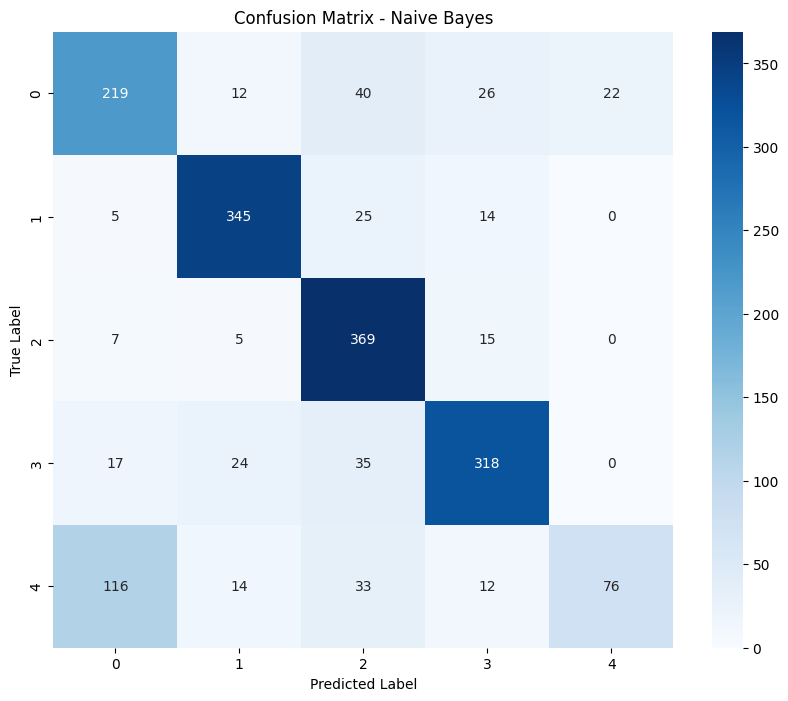

Classification Report - Naive Bayes
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       319
           1       0.86      0.89      0.87       389
           2       0.74      0.93      0.82       396
           3       0.83      0.81      0.82       394
           4       0.78      0.30      0.44       251

    accuracy                           0.76      1749
   macro avg       0.76      0.72      0.72      1749
weighted avg       0.77      0.76      0.74      1749



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Create and train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(train_data_tf_idf, train_data_y)

# Predict the categories of the test data
test_predictions = model.predict(test_data_tf_idf)

# Evaluate the model
accuracy = model.score(test_data_tf_idf, test_data_y)
print(f"Accuracy: {accuracy}")

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred))


# Plot confusion matrix and print classification report
plot_confusion_matrix(test_data_y, test_predictions, "Naive Bayes")



- **Overall Accuracy**: 75.8%, indicating a generally good performance.
- **Best Performing Classes**: Class 1 and Class 2, with high precision and recall.
- **Underperforming Class**: Class 4, showing notably lower recall and F1-score.

**Potential improvement:**

- **Enhanced Preprocessing**: Refining text preprocessing to better handle specific terms or phrases that may be causing confusion between classes.
- **Feature Engineering**: Adding or modifying features such as bigrams or custom token patterns might capture nuances between classes more effectively.


# 4. Two-Layer NN

### Motivation

- **Layer Architecture**:
    - **First Linear Layer**: Converts the input dimension (`num_features`, 5000 from TF-IDF) to 100 nodes, simplifying the data while retaining essential features.
    - **ReLU Activation**: Introduces non-linearity, enhancing the model's ability to learn complex patterns in the data.
    - **Second Linear Layer**: Maps the 100 intermediate nodes to the number of classes (`num_classes`, 5), essential for classification.
    - **LogSoftmax Activation**: Applied to the output to provide a probability distribution over the classes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [32]:
# Convert sparse matrix to dense
train_data_tf_idf = train_data_tf_idf.toarray()
test_data_tf_idf = test_data_tf_idf.toarray()

# Convert to PyTorch tensors
train_x = torch.FloatTensor(train_data_tf_idf)
test_x = torch.FloatTensor(test_data_tf_idf)
train_y = torch.LongTensor(train_data_y)
test_y = torch.LongTensor(test_data_y)

# Create datasets and dataloaders
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
class TextClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(TextClassifier, self).__init__()
        self.layer1 = nn.Linear(num_features, 100)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(100, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        output = self.softmax(x)
        return output

# Initialize the model
model = TextClassifier(num_features=5000, num_classes=5)


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for texts, labels in train_loader:
        # Forward pass
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/10], Loss: 1.4686
Epoch [2/10], Loss: 0.8576
Epoch [3/10], Loss: 0.4935
Epoch [4/10], Loss: 0.2701
Epoch [5/10], Loss: 0.0786
Epoch [6/10], Loss: 0.2750
Epoch [7/10], Loss: 0.1535
Epoch [8/10], Loss: 0.3557
Epoch [9/10], Loss: 0.0380
Epoch [10/10], Loss: 0.0726


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {correct / total:.2f}')


Accuracy: 0.78


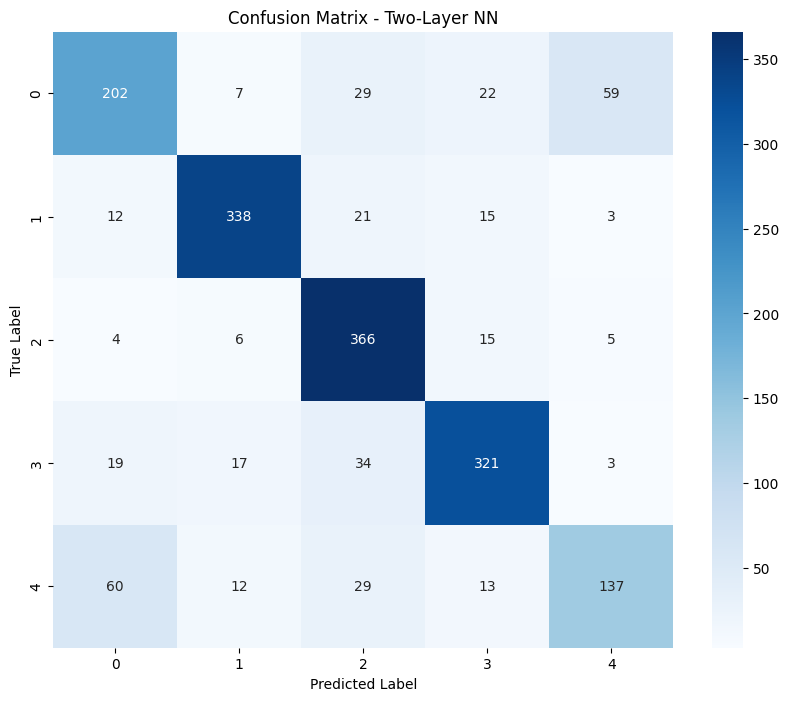

Classification Report - Two-Layer NN
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       319
           1       0.89      0.87      0.88       389
           2       0.76      0.92      0.84       396
           3       0.83      0.81      0.82       394
           4       0.66      0.55      0.60       251

    accuracy                           0.78      1749
   macro avg       0.77      0.76      0.76      1749
weighted avg       0.78      0.78      0.78      1749



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred))

# Collect all predictions
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Plot confusion matrix and print classification report
plot_confusion_matrix(all_labels, all_predictions, "Two-Layer NN")

### Summary:

- **Overall Accuracy**: 78%, indicating relatively high effectiveness.
- **Best Performance**: Class 2 with high precision (0.78) and recall (0.92).
- **Weakest Performance**: Class 4 with the lowest precision (0.63) and recall (0.59).

### Potential Improvements:

- **Class Imbalance Handling**: Maybe implement techniques such as weighted loss or oversampling to address class imbalances, particularly to aid underperforming classes like Class 4.
- **Feature Engineering**: Enhance input features, potentially by including more context or using advanced text representations like word embeddings.
- **Model Complexity**: Maybe add more layers or neurons to capture more complex patterns in the data, or experiment with dropout to reduce overfitting.

# 5. Tokenization and 6. RNN

### Motivation

- **RNN Model Definition**:
    - **Embedding Layer**: Maps token indices to vectors, providing a dense representation of words that captures semantic relationships.
    - **Recurrent Neural Network Layer**: Processes sequences of embeddings, capturing temporal dependencies among words, ideal for text data.
    - **Output Layer**: Transforms RNN outputs to class scores, which are necessary for categorizing text into predefined classes.

50th percentile: 94.0
75th percentile: 184.0
90th percentile: 384.0
95th percentile: 697.0
99th percentile: 2118.359999999986


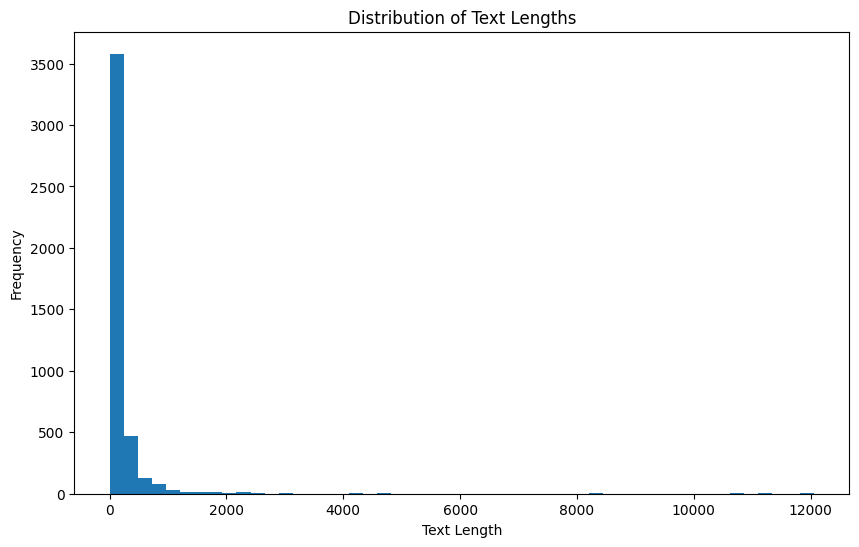

Chosen max_len: 384


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate lengths of all texts
train_lengths = [len(tokenizer(text)) for text in train_data_x]
test_lengths = [len(tokenizer(text)) for text in test_data_x]
all_lengths = train_lengths + test_lengths

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99]
length_percentiles = np.percentile(all_lengths, percentiles)

# Print percentiles
for p, l in zip(percentiles, length_percentiles):
    print(f"{p}th percentile: {l}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(all_lengths, bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


max_len = int(np.percentile(all_lengths, 90))
print(f"Chosen max_len: {max_len}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from collections import Counter
from tqdm import tqdm


tokenizer = get_tokenizer("basic_english")

def tokenize_and_encode(texts, max_len, word_to_idx=None):
    tokenized = [tokenizer(text) for text in texts]
    if word_to_idx is None:
        word_counts = Counter([word for text in tokenized for word in text])
        vocab = ["<PAD>", "<UNK>"] + [word for word, count in word_counts.most_common(9998)]
        word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    encoded = []
    for tokens in tokenized:
        enc = [word_to_idx.get(word, 1) for word in tokens[:max_len]]  # 1 is <UNK>
        enc = enc + [0] * (max_len - len(enc))  # 0 is <PAD>
        encoded.append(enc)

    return encoded, word_to_idx

max_len = 384
X_train, word_to_idx = tokenize_and_encode(train_data_x, max_len)
X_test, _ = tokenize_and_encode(test_data_x, max_len, word_to_idx)

vocab_size = len(word_to_idx)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)

# Encode labels
label_encoder = LabelEncoder()
y_train = torch.tensor(label_encoder.fit_transform(train_data_y), dtype=torch.long)
y_test = torch.tensor(label_encoder.transform(test_data_y), dtype=torch.long)

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

# Hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = 5
batch_size = 64
epochs = 100

# Model, loss, and optimizer
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

for epoch in range(epochs):
    rnn_model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = rnn_model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Evaluation
rnn_model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = rnn_model(X_test)
    _, predicted = torch.max(y_pred, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item():.4f}')

Epoch 1/100: 100%|██████████| 42/42 [00:00<00:00, 88.79it/s]


Epoch 1/100, Loss: 1.6735


Epoch 2/100: 100%|██████████| 42/42 [00:00<00:00, 156.80it/s]


Epoch 2/100, Loss: 1.6461


Epoch 3/100: 100%|██████████| 42/42 [00:00<00:00, 158.50it/s]


Epoch 3/100, Loss: 1.6097


Epoch 4/100: 100%|██████████| 42/42 [00:00<00:00, 175.85it/s]


Epoch 4/100, Loss: 1.6707


Epoch 5/100: 100%|██████████| 42/42 [00:00<00:00, 154.40it/s]


Epoch 5/100, Loss: 1.6235


Epoch 6/100: 100%|██████████| 42/42 [00:00<00:00, 162.66it/s]


Epoch 6/100, Loss: 1.6433


Epoch 7/100: 100%|██████████| 42/42 [00:00<00:00, 174.10it/s]


Epoch 7/100, Loss: 1.6464


Epoch 8/100: 100%|██████████| 42/42 [00:00<00:00, 177.69it/s]


Epoch 8/100, Loss: 1.6118


Epoch 9/100: 100%|██████████| 42/42 [00:00<00:00, 174.72it/s]


Epoch 9/100, Loss: 1.6526


Epoch 10/100: 100%|██████████| 42/42 [00:00<00:00, 173.12it/s]


Epoch 10/100, Loss: 1.6795


Epoch 11/100: 100%|██████████| 42/42 [00:00<00:00, 204.99it/s]


Epoch 11/100, Loss: 1.6230


Epoch 12/100: 100%|██████████| 42/42 [00:00<00:00, 234.42it/s]


Epoch 12/100, Loss: 1.6133


Epoch 13/100: 100%|██████████| 42/42 [00:00<00:00, 235.12it/s]


Epoch 13/100, Loss: 1.6417


Epoch 14/100: 100%|██████████| 42/42 [00:00<00:00, 215.37it/s]


Epoch 14/100, Loss: 1.6000


Epoch 15/100: 100%|██████████| 42/42 [00:00<00:00, 235.98it/s]


Epoch 15/100, Loss: 1.5896


Epoch 16/100: 100%|██████████| 42/42 [00:00<00:00, 219.49it/s]


Epoch 16/100, Loss: 1.6404


Epoch 17/100: 100%|██████████| 42/42 [00:00<00:00, 231.18it/s]


Epoch 17/100, Loss: 1.5884


Epoch 18/100: 100%|██████████| 42/42 [00:00<00:00, 230.55it/s]


Epoch 18/100, Loss: 1.6008


Epoch 19/100: 100%|██████████| 42/42 [00:00<00:00, 217.16it/s]


Epoch 19/100, Loss: 1.5801


Epoch 20/100: 100%|██████████| 42/42 [00:00<00:00, 237.53it/s]


Epoch 20/100, Loss: 1.6556


Epoch 21/100: 100%|██████████| 42/42 [00:00<00:00, 222.74it/s]


Epoch 21/100, Loss: 1.5944


Epoch 22/100: 100%|██████████| 42/42 [00:00<00:00, 234.69it/s]


Epoch 22/100, Loss: 1.5690


Epoch 23/100: 100%|██████████| 42/42 [00:00<00:00, 228.33it/s]


Epoch 23/100, Loss: 1.5801


Epoch 24/100: 100%|██████████| 42/42 [00:00<00:00, 224.34it/s]


Epoch 24/100, Loss: 1.5624


Epoch 25/100: 100%|██████████| 42/42 [00:00<00:00, 234.18it/s]


Epoch 25/100, Loss: 1.5472


Epoch 26/100: 100%|██████████| 42/42 [00:00<00:00, 232.59it/s]


Epoch 26/100, Loss: 1.5729


Epoch 27/100: 100%|██████████| 42/42 [00:00<00:00, 218.53it/s]


Epoch 27/100, Loss: 1.5667


Epoch 28/100: 100%|██████████| 42/42 [00:00<00:00, 228.64it/s]


Epoch 28/100, Loss: 1.5340


Epoch 29/100: 100%|██████████| 42/42 [00:00<00:00, 215.50it/s]


Epoch 29/100, Loss: 1.5730


Epoch 30/100: 100%|██████████| 42/42 [00:00<00:00, 223.06it/s]


Epoch 30/100, Loss: 1.5377


Epoch 31/100: 100%|██████████| 42/42 [00:00<00:00, 222.10it/s]


Epoch 31/100, Loss: 1.5619


Epoch 32/100: 100%|██████████| 42/42 [00:00<00:00, 222.14it/s]


Epoch 32/100, Loss: 1.5443


Epoch 33/100: 100%|██████████| 42/42 [00:00<00:00, 209.26it/s]


Epoch 33/100, Loss: 1.5424


Epoch 34/100: 100%|██████████| 42/42 [00:00<00:00, 223.69it/s]


Epoch 34/100, Loss: 1.5451


Epoch 35/100: 100%|██████████| 42/42 [00:00<00:00, 231.14it/s]


Epoch 35/100, Loss: 1.5524


Epoch 36/100: 100%|██████████| 42/42 [00:00<00:00, 234.57it/s]


Epoch 36/100, Loss: 1.5815


Epoch 37/100: 100%|██████████| 42/42 [00:00<00:00, 219.15it/s]


Epoch 37/100, Loss: 1.5207


Epoch 38/100: 100%|██████████| 42/42 [00:00<00:00, 234.50it/s]


Epoch 38/100, Loss: 1.5219


Epoch 39/100: 100%|██████████| 42/42 [00:00<00:00, 224.41it/s]


Epoch 39/100, Loss: 1.5165


Epoch 40/100: 100%|██████████| 42/42 [00:00<00:00, 225.15it/s]


Epoch 40/100, Loss: 1.5446


Epoch 41/100: 100%|██████████| 42/42 [00:00<00:00, 233.10it/s]


Epoch 41/100, Loss: 1.5104


Epoch 42/100: 100%|██████████| 42/42 [00:00<00:00, 222.53it/s]


Epoch 42/100, Loss: 1.5162


Epoch 43/100: 100%|██████████| 42/42 [00:00<00:00, 230.62it/s]


Epoch 43/100, Loss: 1.5227


Epoch 44/100: 100%|██████████| 42/42 [00:00<00:00, 230.33it/s]


Epoch 44/100, Loss: 1.5540


Epoch 45/100: 100%|██████████| 42/42 [00:00<00:00, 216.85it/s]


Epoch 45/100, Loss: 1.5413


Epoch 46/100: 100%|██████████| 42/42 [00:00<00:00, 233.37it/s]


Epoch 46/100, Loss: 1.5328


Epoch 47/100: 100%|██████████| 42/42 [00:00<00:00, 230.33it/s]


Epoch 47/100, Loss: 1.4887


Epoch 48/100: 100%|██████████| 42/42 [00:00<00:00, 222.75it/s]


Epoch 48/100, Loss: 1.5213


Epoch 49/100: 100%|██████████| 42/42 [00:00<00:00, 232.12it/s]


Epoch 49/100, Loss: 1.4977


Epoch 50/100: 100%|██████████| 42/42 [00:00<00:00, 215.82it/s]


Epoch 50/100, Loss: 1.5061


Epoch 51/100: 100%|██████████| 42/42 [00:00<00:00, 238.06it/s]


Epoch 51/100, Loss: 1.5439


Epoch 52/100: 100%|██████████| 42/42 [00:00<00:00, 228.64it/s]


Epoch 52/100, Loss: 1.5135


Epoch 53/100: 100%|██████████| 42/42 [00:00<00:00, 226.14it/s]


Epoch 53/100, Loss: 1.5329


Epoch 54/100: 100%|██████████| 42/42 [00:00<00:00, 233.42it/s]


Epoch 54/100, Loss: 1.5071


Epoch 55/100: 100%|██████████| 42/42 [00:00<00:00, 215.99it/s]


Epoch 55/100, Loss: 1.5093


Epoch 56/100: 100%|██████████| 42/42 [00:00<00:00, 235.84it/s]


Epoch 56/100, Loss: 1.5069


Epoch 57/100: 100%|██████████| 42/42 [00:00<00:00, 230.27it/s]


Epoch 57/100, Loss: 1.5142


Epoch 58/100: 100%|██████████| 42/42 [00:00<00:00, 229.15it/s]


Epoch 58/100, Loss: 1.5109


Epoch 59/100: 100%|██████████| 42/42 [00:00<00:00, 237.39it/s]


Epoch 59/100, Loss: 1.5187


Epoch 60/100: 100%|██████████| 42/42 [00:00<00:00, 224.29it/s]


Epoch 60/100, Loss: 1.5128


Epoch 61/100: 100%|██████████| 42/42 [00:00<00:00, 233.86it/s]


Epoch 61/100, Loss: 1.4987


Epoch 62/100: 100%|██████████| 42/42 [00:00<00:00, 234.13it/s]


Epoch 62/100, Loss: 1.4842


Epoch 63/100: 100%|██████████| 42/42 [00:00<00:00, 172.85it/s]


Epoch 63/100, Loss: 1.4988


Epoch 64/100: 100%|██████████| 42/42 [00:00<00:00, 176.70it/s]


Epoch 64/100, Loss: 1.4843


Epoch 65/100: 100%|██████████| 42/42 [00:00<00:00, 179.86it/s]


Epoch 65/100, Loss: 1.4683


Epoch 66/100: 100%|██████████| 42/42 [00:00<00:00, 180.82it/s]


Epoch 66/100, Loss: 1.4915


Epoch 67/100: 100%|██████████| 42/42 [00:00<00:00, 180.95it/s]


Epoch 67/100, Loss: 1.4790


Epoch 68/100: 100%|██████████| 42/42 [00:00<00:00, 170.68it/s]


Epoch 68/100, Loss: 1.4845


Epoch 69/100: 100%|██████████| 42/42 [00:00<00:00, 158.76it/s]


Epoch 69/100, Loss: 1.5045


Epoch 70/100: 100%|██████████| 42/42 [00:00<00:00, 173.27it/s]


Epoch 70/100, Loss: 1.4897


Epoch 71/100: 100%|██████████| 42/42 [00:00<00:00, 178.60it/s]


Epoch 71/100, Loss: 1.5058


Epoch 72/100: 100%|██████████| 42/42 [00:00<00:00, 174.58it/s]


Epoch 72/100, Loss: 1.5210


Epoch 73/100: 100%|██████████| 42/42 [00:00<00:00, 168.58it/s]


Epoch 73/100, Loss: 1.4903


Epoch 74/100: 100%|██████████| 42/42 [00:00<00:00, 190.54it/s]


Epoch 74/100, Loss: 1.4722


Epoch 75/100: 100%|██████████| 42/42 [00:00<00:00, 232.05it/s]


Epoch 75/100, Loss: 1.4953


Epoch 76/100: 100%|██████████| 42/42 [00:00<00:00, 230.57it/s]


Epoch 76/100, Loss: 1.5243


Epoch 77/100: 100%|██████████| 42/42 [00:00<00:00, 219.26it/s]


Epoch 77/100, Loss: 1.5258


Epoch 78/100: 100%|██████████| 42/42 [00:00<00:00, 219.64it/s]


Epoch 78/100, Loss: 1.4897


Epoch 79/100: 100%|██████████| 42/42 [00:00<00:00, 232.21it/s]


Epoch 79/100, Loss: 1.4902


Epoch 80/100: 100%|██████████| 42/42 [00:00<00:00, 229.90it/s]


Epoch 80/100, Loss: 1.4905


Epoch 81/100: 100%|██████████| 42/42 [00:00<00:00, 230.57it/s]


Epoch 81/100, Loss: 1.4902


Epoch 82/100: 100%|██████████| 42/42 [00:00<00:00, 220.17it/s]


Epoch 82/100, Loss: 1.4883


Epoch 83/100: 100%|██████████| 42/42 [00:00<00:00, 190.66it/s]


Epoch 83/100, Loss: 1.5091


Epoch 84/100: 100%|██████████| 42/42 [00:00<00:00, 229.21it/s]


Epoch 84/100, Loss: 1.5160


Epoch 85/100: 100%|██████████| 42/42 [00:00<00:00, 221.18it/s]


Epoch 85/100, Loss: 1.5213


Epoch 86/100: 100%|██████████| 42/42 [00:00<00:00, 229.42it/s]


Epoch 86/100, Loss: 1.5255


Epoch 87/100: 100%|██████████| 42/42 [00:00<00:00, 222.23it/s]


Epoch 87/100, Loss: 1.5248


Epoch 88/100: 100%|██████████| 42/42 [00:00<00:00, 217.49it/s]


Epoch 88/100, Loss: 1.4639


Epoch 89/100: 100%|██████████| 42/42 [00:00<00:00, 234.69it/s]


Epoch 89/100, Loss: 1.4693


Epoch 90/100: 100%|██████████| 42/42 [00:00<00:00, 232.06it/s]


Epoch 90/100, Loss: 1.4712


Epoch 91/100: 100%|██████████| 42/42 [00:00<00:00, 229.83it/s]


Epoch 91/100, Loss: 1.5020


Epoch 92/100: 100%|██████████| 42/42 [00:00<00:00, 222.05it/s]


Epoch 92/100, Loss: 1.4931


Epoch 93/100: 100%|██████████| 42/42 [00:00<00:00, 218.78it/s]


Epoch 93/100, Loss: 1.5311


Epoch 94/100: 100%|██████████| 42/42 [00:00<00:00, 234.58it/s]


Epoch 94/100, Loss: 1.5220


Epoch 95/100: 100%|██████████| 42/42 [00:00<00:00, 230.55it/s]


Epoch 95/100, Loss: 1.5140


Epoch 96/100: 100%|██████████| 42/42 [00:00<00:00, 229.33it/s]


Epoch 96/100, Loss: 1.5051


Epoch 97/100: 100%|██████████| 42/42 [00:00<00:00, 227.85it/s]


Epoch 97/100, Loss: 1.5072


Epoch 98/100: 100%|██████████| 42/42 [00:00<00:00, 208.35it/s]


Epoch 98/100, Loss: 1.5220


Epoch 99/100: 100%|██████████| 42/42 [00:00<00:00, 234.69it/s]


Epoch 99/100, Loss: 1.5046


Epoch 100/100: 100%|██████████| 42/42 [00:00<00:00, 229.34it/s]


Epoch 100/100, Loss: 1.5158
Test Accuracy: 0.2419


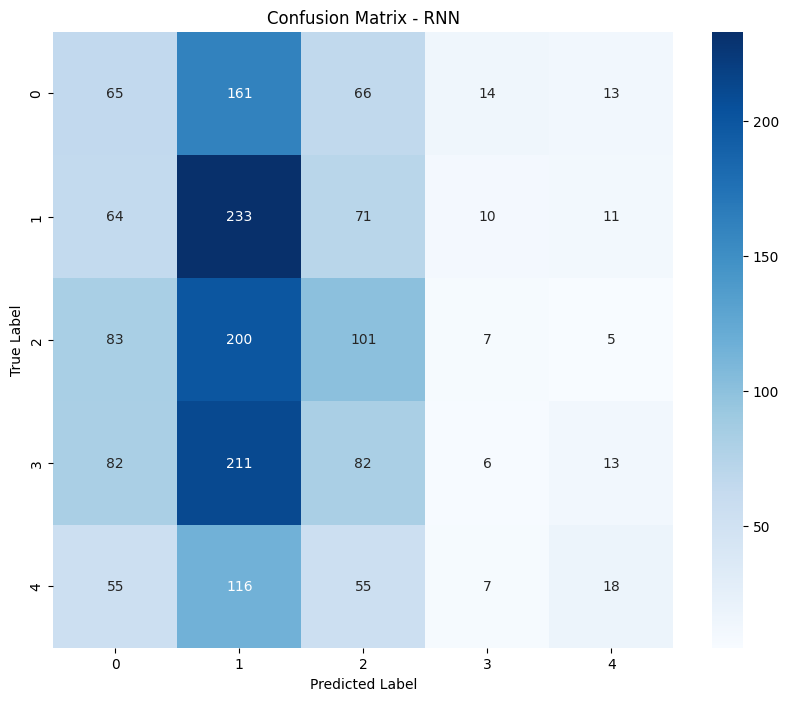

Classification Report - RNN
              precision    recall  f1-score   support

           0       0.19      0.20      0.19       319
           1       0.25      0.60      0.36       389
           2       0.27      0.26      0.26       396
           3       0.14      0.02      0.03       394
           4       0.30      0.07      0.12       251

    accuracy                           0.24      1749
   macro avg       0.23      0.23      0.19      1749
weighted avg       0.22      0.24      0.20      1749



In [ ]:


# Convert predictions and true labels to numpy arrays
y_pred_np = predicted.cpu().numpy()
y_true_np = y_test.cpu().numpy()

# Plot confusion matrix and print classification report
plot_confusion_matrix(y_true_np, y_pred_np, "RNN")



### Summary:

- **Overall Accuracy**: 24%, indicating low model performance. This is due to the vanashing gradient issue with RNNs, that's why we use better models later.
- **Class Performance**:
    - **Class 1**: Best performance with decent recall (0.83), but still low precision.
    - **Other Classes**: Very low precision and recall across Classes 0, 2, 3, and 4, showing substantial misclassification.

### Potential Improvements:

- **Model Complexity**: Maybe increase the complexity of the model with more layers.
- **Feature Engineering**: Could consider using more sophisticated text representations like word embeddings (pre-trained like GloVe or Word2Vec) to provide richer input features.
- **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, or optimizer settings to find more optimal model parameters.

# 7.GRU

### Motivation

- **GRU Neural Network Architecture**:
    - **Embedding Layer**: Translates token indices into dense vectors to capture semantic meanings, essential for understanding text data.
    - **GRU Layer**: Utilizes Gated Recurrent Units to effectively capture temporal dependencies and long-range contexts within text sequences, improving sequence modeling over simpler RNNs.
    - **Fully Connected Output Layer**: Maps the high-level features extracted by the GRU to the output classes.

Epoch 1/50: 100%|██████████| 42/42 [00:00<00:00, 50.08it/s]


Epoch 1/50, Loss: 1.5946


Epoch 2/50: 100%|██████████| 42/42 [00:00<00:00, 114.34it/s]


Epoch 2/50, Loss: 1.5381


Epoch 3/50: 100%|██████████| 42/42 [00:00<00:00, 116.82it/s]


Epoch 3/50, Loss: 1.4426


Epoch 4/50: 100%|██████████| 42/42 [00:00<00:00, 116.75it/s]


Epoch 4/50, Loss: 0.9416


Epoch 5/50: 100%|██████████| 42/42 [00:00<00:00, 116.23it/s]


Epoch 5/50, Loss: 0.3924


Epoch 6/50: 100%|██████████| 42/42 [00:00<00:00, 117.84it/s]


Epoch 6/50, Loss: 0.1639


Epoch 7/50: 100%|██████████| 42/42 [00:00<00:00, 114.30it/s]


Epoch 7/50, Loss: 0.0874


Epoch 8/50: 100%|██████████| 42/42 [00:00<00:00, 115.57it/s]


Epoch 8/50, Loss: 0.0646


Epoch 9/50: 100%|██████████| 42/42 [00:00<00:00, 117.96it/s]


Epoch 9/50, Loss: 0.0649


Epoch 10/50: 100%|██████████| 42/42 [00:00<00:00, 114.87it/s]


Epoch 10/50, Loss: 0.0617


Epoch 11/50: 100%|██████████| 42/42 [00:00<00:00, 115.87it/s]


Epoch 11/50, Loss: 0.0584


Epoch 12/50: 100%|██████████| 42/42 [00:00<00:00, 116.06it/s]


Epoch 12/50, Loss: 0.0585


Epoch 13/50: 100%|██████████| 42/42 [00:00<00:00, 114.93it/s]


Epoch 13/50, Loss: 0.0565


Epoch 14/50: 100%|██████████| 42/42 [00:00<00:00, 117.86it/s]


Epoch 14/50, Loss: 0.0555


Epoch 15/50: 100%|██████████| 42/42 [00:00<00:00, 115.96it/s]


Epoch 15/50, Loss: 0.0550


Epoch 16/50: 100%|██████████| 42/42 [00:00<00:00, 115.61it/s]


Epoch 16/50, Loss: 0.0571


Epoch 17/50: 100%|██████████| 42/42 [00:00<00:00, 114.29it/s]


Epoch 17/50, Loss: 0.0682


Epoch 18/50: 100%|██████████| 42/42 [00:00<00:00, 115.82it/s]


Epoch 18/50, Loss: 0.0615


Epoch 19/50: 100%|██████████| 42/42 [00:00<00:00, 115.85it/s]


Epoch 19/50, Loss: 0.0551


Epoch 20/50: 100%|██████████| 42/42 [00:00<00:00, 115.67it/s]


Epoch 20/50, Loss: 0.0542


Epoch 21/50: 100%|██████████| 42/42 [00:00<00:00, 114.25it/s]


Epoch 21/50, Loss: 0.0539


Epoch 22/50: 100%|██████████| 42/42 [00:00<00:00, 107.75it/s]


Epoch 22/50, Loss: 0.0676


Epoch 23/50: 100%|██████████| 42/42 [00:00<00:00, 109.06it/s]


Epoch 23/50, Loss: 0.0607


Epoch 24/50: 100%|██████████| 42/42 [00:00<00:00, 107.38it/s]


Epoch 24/50, Loss: 0.0535


Epoch 25/50: 100%|██████████| 42/42 [00:00<00:00, 110.10it/s]


Epoch 25/50, Loss: 0.0636


Epoch 26/50: 100%|██████████| 42/42 [00:00<00:00, 108.34it/s]


Epoch 26/50, Loss: 0.0612


Epoch 27/50: 100%|██████████| 42/42 [00:00<00:00, 109.65it/s]


Epoch 27/50, Loss: 0.0549


Epoch 28/50: 100%|██████████| 42/42 [00:00<00:00, 110.29it/s]


Epoch 28/50, Loss: 0.0537


Epoch 29/50: 100%|██████████| 42/42 [00:00<00:00, 110.09it/s]


Epoch 29/50, Loss: 0.0535


Epoch 30/50: 100%|██████████| 42/42 [00:00<00:00, 117.54it/s]


Epoch 30/50, Loss: 0.0527


Epoch 31/50: 100%|██████████| 42/42 [00:00<00:00, 116.95it/s]


Epoch 31/50, Loss: 0.0637


Epoch 32/50: 100%|██████████| 42/42 [00:00<00:00, 116.22it/s]


Epoch 32/50, Loss: 0.0592


Epoch 33/50: 100%|██████████| 42/42 [00:00<00:00, 118.74it/s]


Epoch 33/50, Loss: 0.0520


Epoch 34/50: 100%|██████████| 42/42 [00:00<00:00, 115.41it/s]


Epoch 34/50, Loss: 0.0536


Epoch 35/50: 100%|██████████| 42/42 [00:00<00:00, 117.41it/s]


Epoch 35/50, Loss: 0.0592


Epoch 36/50: 100%|██████████| 42/42 [00:00<00:00, 117.88it/s]


Epoch 36/50, Loss: 0.0570


Epoch 37/50: 100%|██████████| 42/42 [00:00<00:00, 115.93it/s]


Epoch 37/50, Loss: 0.0536


Epoch 38/50: 100%|██████████| 42/42 [00:00<00:00, 116.93it/s]


Epoch 38/50, Loss: 0.0526


Epoch 39/50: 100%|██████████| 42/42 [00:00<00:00, 118.05it/s]


Epoch 39/50, Loss: 0.0535


Epoch 40/50: 100%|██████████| 42/42 [00:00<00:00, 115.15it/s]


Epoch 40/50, Loss: 0.0645


Epoch 41/50: 100%|██████████| 42/42 [00:00<00:00, 117.09it/s]


Epoch 41/50, Loss: 0.0573


Epoch 42/50: 100%|██████████| 42/42 [00:00<00:00, 117.10it/s]


Epoch 42/50, Loss: 0.0522


Epoch 43/50: 100%|██████████| 42/42 [00:00<00:00, 114.56it/s]


Epoch 43/50, Loss: 0.0516


Epoch 44/50: 100%|██████████| 42/42 [00:00<00:00, 118.22it/s]


Epoch 44/50, Loss: 0.0527


Epoch 45/50: 100%|██████████| 42/42 [00:00<00:00, 117.28it/s]


Epoch 45/50, Loss: 0.0530


Epoch 46/50: 100%|██████████| 42/42 [00:00<00:00, 115.24it/s]


Epoch 46/50, Loss: 0.0536


Epoch 47/50: 100%|██████████| 42/42 [00:00<00:00, 117.86it/s]


Epoch 47/50, Loss: 0.0524


Epoch 48/50: 100%|██████████| 42/42 [00:00<00:00, 114.86it/s]


Epoch 48/50, Loss: 0.0541


Epoch 49/50: 100%|██████████| 42/42 [00:00<00:00, 117.42it/s]


Epoch 49/50, Loss: 0.0532


Epoch 50/50: 100%|██████████| 42/42 [00:00<00:00, 117.00it/s]


Epoch 50/50, Loss: 0.0530
Test Accuracy: 0.6804


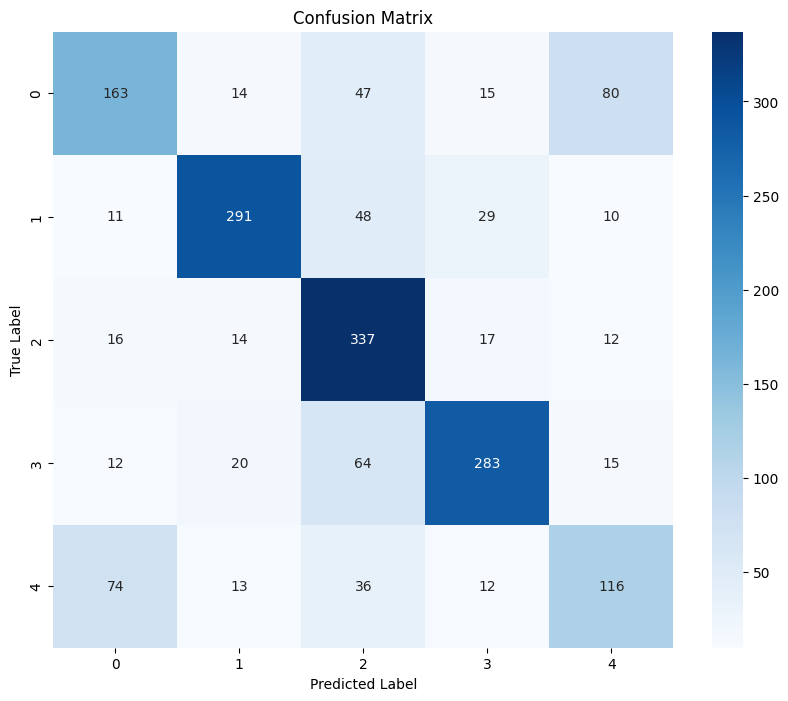

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from collections import Counter
from tqdm import tqdm
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

# Tokenizer
tokenizer = get_tokenizer("basic_english")

# Train Word2Vec model
def train_word2vec(texts, vector_size=100, window=5, min_count=1, workers=4):
    tokenized_data = [tokenizer(text) for text in texts]
    model = Word2Vec(sentences=tokenized_data, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

# Create embedding matrix
def create_embedding_matrix(word2vec_model, word_to_idx, embedding_dim):
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, idx in word_to_idx.items():
        if word in word2vec_model.wv:
            embedding_matrix[idx] = word2vec_model.wv[word]
    return torch.FloatTensor(embedding_matrix)

# Tokenize and encode
def tokenize_and_encode(texts, max_len, word2vec_model, word_to_idx=None):
    tokenized = [tokenizer(text) for text in texts]
    if word_to_idx is None:
        word_counts = Counter([word for text in tokenized for word in text])
        vocab = ["<PAD>", "<UNK>"] + [word for word, count in word_counts.most_common() if word in word2vec_model.wv]
        word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    encoded = []
    for tokens in tokenized:
        enc = [word_to_idx.get(word, 1) for word in tokens[:max_len] if word in word_to_idx]  # 1 is <UNK>
        enc = enc + [0] * (max_len - len(enc))  # 0 is <PAD>
        encoded.append(enc)

    return encoded, word_to_idx

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        _, hidden = self.gru(embedded)
        return self.fc(hidden.squeeze(0))

# Main process
def main(train_data_x, train_data_y, test_data_x, test_data_y):
        # Train Word2Vec
    word2vec_model = train_word2vec(train_data_x)
    embedding_dim = word2vec_model.vector_size

    # Tokenize and encode
    max_len = 384
    X_train, word_to_idx = tokenize_and_encode(train_data_x, max_len, word2vec_model)
    X_test, _ = tokenize_and_encode(test_data_x, max_len, word2vec_model, word_to_idx)

    vocab_size = len(word_to_idx)

    # Create embedding matrix
    embedding_matrix = create_embedding_matrix(word2vec_model, word_to_idx, embedding_dim)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.long)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(train_data_y), dtype=torch.long)
    y_test = torch.tensor(label_encoder.transform(test_data_y), dtype=torch.long)

    # Hyperparameters
    hidden_dim = 128
    output_dim = len(label_encoder.classes_)
    batch_size = 64
    epochs = 50
    learning_rate = 0.01

    # Create the model
    model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        _, predicted = torch.max(y_pred, 1)
        accuracy = (predicted == y_test).float().mean()
        print(f'Test Accuracy: {accuracy:.4f}')

        # Confusion Matrix
        y_true = y_test.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Run the main process
if __name__ == "__main__":

    main(train_data_x, train_data_y, test_data_x, test_data_y)

### Summary:

- **Overall Accuracy**: 68%, showing relatively high effectiveness.


### Potential Improvements:

- **Class-Specific Strategies**: Focus on improving features or weighting strategies for underperforming classes like Class 0 and Class 4.
- **Hyperparameter Tuning**: Experiment with different configurations of GRU parameters, such as number of layers, hidden units, or learning rates.
- **Advanced Embeddings**: Utilize more sophisticated embeddings like GloVe or fine-tuning BERT embeddings to capture richer semantic information.
- **Data Augmentation**: Increase the diversity and amount of training data for underrepresented classes to improve generalization.

# 8. LSTM

### Motivation

- **LSTM Architecture**: Utilizes an LSTM (Long Short-Term Memory) network which is effective for learning dependencies in sequence data, crucial for tasks like text processing where context is key.
    - **Embedding Layer**: Maps token indices to dense vector representations, capturing semantic meanings of words.
    - **LSTM Layers**: Configured to be bidirectional and potentially multilayered, enhancing the model’s ability to capture patterns from both past and future context.
    - **Dropout**: Applied to prevent overfitting by randomly omitting subsets of features during training.
    - **Output Layer**: Computes class scores from LSTM outputs, which are then used for classification.
- **Training Loop with Early Stopping**:
    - **Epochs and Batch Processing**: Trains the model over multiple epochs, adjusting weights to minimize loss, and uses batches to make computation manageable.
    - **Early Stopping**: Monitors validation loss to halt training when improvement stalls, preventing overfitting and saving computational resources.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(self.dropout(hidden))

# Hyperparameters
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 256
output_dim = 5
n_layers = 2
bidirectional = True
dropout = 0.5
batch_size = 64
epochs = 50
learning_rate = 0.01

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Create the model and move it to device
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create dataset and split into train and validation
train_dataset = TensorDataset(X_train, y_train)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        texts, labels = batch

        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch
            predictions = model(texts)
            loss = criterion(predictions, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_lstm_model.pth'))

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, predicted = torch.max(y_pred, 1)
    accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/50: 100%|██████████| 33/33 [00:02<00:00, 13.15it/s]


Epoch 1/50, Train Loss: 1.6288, Val Loss: 1.6069


Epoch 2/50: 100%|██████████| 33/33 [00:02<00:00, 13.11it/s]


Epoch 2/50, Train Loss: 1.5397, Val Loss: 1.5295


Epoch 3/50: 100%|██████████| 33/33 [00:02<00:00, 12.99it/s]


Epoch 3/50, Train Loss: 1.4620, Val Loss: 1.4756


Epoch 4/50: 100%|██████████| 33/33 [00:02<00:00, 12.99it/s]


Epoch 4/50, Train Loss: 1.3743, Val Loss: 1.5105


Epoch 5/50: 100%|██████████| 33/33 [00:02<00:00, 13.01it/s]


Epoch 5/50, Train Loss: 1.3377, Val Loss: 1.5738


Epoch 6/50: 100%|██████████| 33/33 [00:02<00:00, 12.91it/s]


Epoch 6/50, Train Loss: 1.4212, Val Loss: 1.5606


Epoch 7/50: 100%|██████████| 33/33 [00:02<00:00, 12.95it/s]


Epoch 7/50, Train Loss: 1.2700, Val Loss: 1.3899


Epoch 8/50: 100%|██████████| 33/33 [00:02<00:00, 12.87it/s]


Epoch 8/50, Train Loss: 1.1750, Val Loss: 1.3239


Epoch 9/50: 100%|██████████| 33/33 [00:02<00:00, 12.83it/s]


Epoch 9/50, Train Loss: 1.0172, Val Loss: 1.2520


Epoch 10/50: 100%|██████████| 33/33 [00:02<00:00, 12.95it/s]


Epoch 10/50, Train Loss: 0.9374, Val Loss: 1.2218


Epoch 11/50: 100%|██████████| 33/33 [00:02<00:00, 12.88it/s]


Epoch 11/50, Train Loss: 0.9769, Val Loss: 1.4053


Epoch 12/50: 100%|██████████| 33/33 [00:02<00:00, 12.87it/s]


Epoch 12/50, Train Loss: 0.8803, Val Loss: 1.1726


Epoch 13/50: 100%|██████████| 33/33 [00:02<00:00, 12.92it/s]


Epoch 13/50, Train Loss: 0.7814, Val Loss: 1.2253


Epoch 14/50: 100%|██████████| 33/33 [00:02<00:00, 12.93it/s]


Epoch 14/50, Train Loss: 0.7745, Val Loss: 1.0406


Epoch 15/50: 100%|██████████| 33/33 [00:02<00:00, 12.96it/s]


Epoch 15/50, Train Loss: 0.7076, Val Loss: 1.0682


Epoch 16/50: 100%|██████████| 33/33 [00:02<00:00, 12.96it/s]


Epoch 16/50, Train Loss: 0.7039, Val Loss: 1.0840


Epoch 17/50: 100%|██████████| 33/33 [00:02<00:00, 11.72it/s]


Epoch 17/50, Train Loss: 0.6611, Val Loss: 1.0318


Epoch 18/50: 100%|██████████| 33/33 [00:02<00:00, 12.97it/s]


Epoch 18/50, Train Loss: 0.7141, Val Loss: 1.1121


Epoch 19/50: 100%|██████████| 33/33 [00:02<00:00, 12.98it/s]


Epoch 19/50, Train Loss: 0.7226, Val Loss: 1.1475


Epoch 20/50: 100%|██████████| 33/33 [00:02<00:00, 13.02it/s]


Epoch 20/50, Train Loss: 0.7243, Val Loss: 1.0107


Epoch 21/50: 100%|██████████| 33/33 [00:02<00:00, 12.43it/s]


Epoch 21/50, Train Loss: 0.6834, Val Loss: 0.9987


Epoch 22/50: 100%|██████████| 33/33 [00:02<00:00, 12.95it/s]


Epoch 22/50, Train Loss: 0.7151, Val Loss: 0.8952


Epoch 23/50: 100%|██████████| 33/33 [00:02<00:00, 13.05it/s]


Epoch 23/50, Train Loss: 0.6562, Val Loss: 1.0139


Epoch 24/50: 100%|██████████| 33/33 [00:02<00:00, 13.08it/s]


Epoch 24/50, Train Loss: 0.6418, Val Loss: 0.8772


Epoch 25/50: 100%|██████████| 33/33 [00:02<00:00, 13.02it/s]


Epoch 25/50, Train Loss: 0.6702, Val Loss: 1.0343


Epoch 26/50: 100%|██████████| 33/33 [00:02<00:00, 13.01it/s]


Epoch 26/50, Train Loss: 0.6978, Val Loss: 0.9878


Epoch 27/50: 100%|██████████| 33/33 [00:02<00:00, 13.04it/s]


Epoch 27/50, Train Loss: 0.7703, Val Loss: 0.9822


Epoch 28/50: 100%|██████████| 33/33 [00:02<00:00, 13.00it/s]


Epoch 28/50, Train Loss: 0.8090, Val Loss: 0.9936


Epoch 29/50: 100%|██████████| 33/33 [00:02<00:00, 12.74it/s]


Epoch 29/50, Train Loss: 0.8771, Val Loss: 1.2173
Early stopping triggered after 29 epochs
Test Accuracy: 0.6318


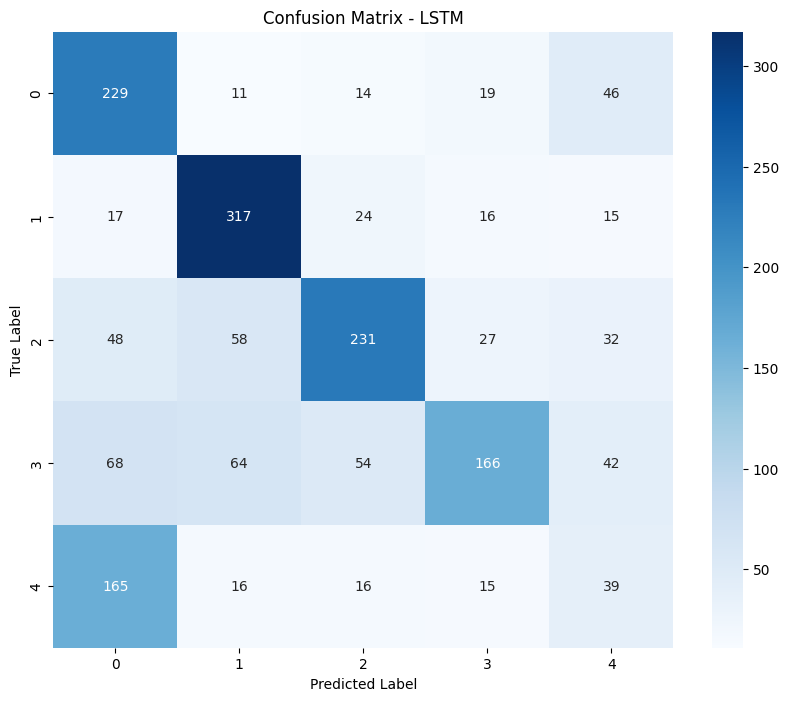

Classification Report - LSTM
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       319
           1       0.68      0.81      0.74       389
           2       0.68      0.58      0.63       396
           3       0.68      0.42      0.52       394
           4       0.22      0.16      0.18       251

    accuracy                           0.56      1749
   macro avg       0.54      0.54      0.52      1749
weighted avg       0.57      0.56      0.55      1749



In [ ]:
# Convert predictions and true labels to numpy arrays
y_pred_np = predicted.cpu().numpy()
y_true_np = y_test.cpu().numpy()

# Plot confusion matrix and print classification report
plot_confusion_matrix(y_true_np, y_pred_np, "LSTM")

### Summary:

Accuracy: 63%

- **Classification Metrics:**
    - **Precision:** Varies from 0.22 (class 4) to 0.68 (class 2).
    - **Recall:** Ranges from 0.16 (class 4) to 0.81 (class 1).
    - **F1-Score:** Spans from 0.18 (class 4) to 0.74 (class 2).

### Potential Improvements:

1. **Hyperparameter Tuning:** Adjust the LSTM parameters or experiment with different architectures.
2. **Feature Engineering:** Explore more sophisticated text features or embeddings to enhance model accuracy.